# MM libs

In [87]:
import mmcv
import mmrotate
import mmdet
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
# Check mmcv installation
print(mmcv.__version__) #noqa E1101
# Check MMRotate installation
print(mmrotate.__version__)
print(mmrotate.__file__)
# Check MMDetection installation
print(mmdet.__version__)

import mmengine
print(mmengine.__version__)

print(get_compiling_cuda_version())
print(get_compiler_version())

2.0.0
1.0.0rc1
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/mmrotate/mmrotate/__init__.py
3.1.0
0.10.3
11.1
GCC 7.3


In [88]:
from mmengine.config import Config
from mmengine.runner import Runner

from mmdet.utils import register_all_modules as register_all_modules_mmdet
from mmdet.apis import inference_detector, init_detector

from mmrotate.registry import VISUALIZERS
from mmrotate.utils import register_all_modules

# SAM Libs

In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/SAM_RS/Generate Dataset")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide
from loaddata import load_hrsc, load_dota

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_utils

import numpy as np
import xml.etree.ElementTree as ET
import os.path as osp
import easydict

# Inference MTP

In [90]:
# register all modules in mmdet into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules_mmdet(init_default_scope=False)
register_all_modules(init_default_scope=False)

# Choose to use a config and initialize the detector
config = '/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/work_dir/oriented_rcnn_rvsa_l_1024_mae_mtp_dota10_adjust_v1.py'
# Setup a checkpoint file to load
# 9 epoch => recall : 0.92, ap : 0.838 
checkpoint = '/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/work_dir/epoch_9.pth'
# Set work_dir
work_dir = '/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/work_dir'
# Set the device to be used for evaluation
device='cuda:0'
# Set inference path

cfg = Config.fromfile(config)
cfg.load_from = checkpoint
cfg.work_dir = work_dir

# register all modules in mmrotate into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(cfg, checkpoint, palette="dota", device=device)
model

The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
Loads checkpoint by local backend from path: /mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/01.SAMRS_MTP/MTP/MMRotate_1_x/work_dir/epoch_9.pth


FasterRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): RVSA_MTP_branches(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): RotatedVariedSizeWindowAttention(
          (sampling_offsets): Sequential(
            (0): AvgPool2d(kernel_size=7, stride=7, padding=0)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (sampling_scales): Sequential(
            (0): AvgPool2d(kernel_size=7, stride=7, padding=0)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Conv2d(1024, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (sampling_angles): Sequential(
            (0): AvgPool2d(kernel_size=7, stride=7, padding=0)
            (1): Leak

In [91]:
model.cfg.visualizer

{'name': 'visualizer',
 'type': 'RotLocalVisualizer',
 'vis_backends': [{'type': 'LocalVisBackend'}]}

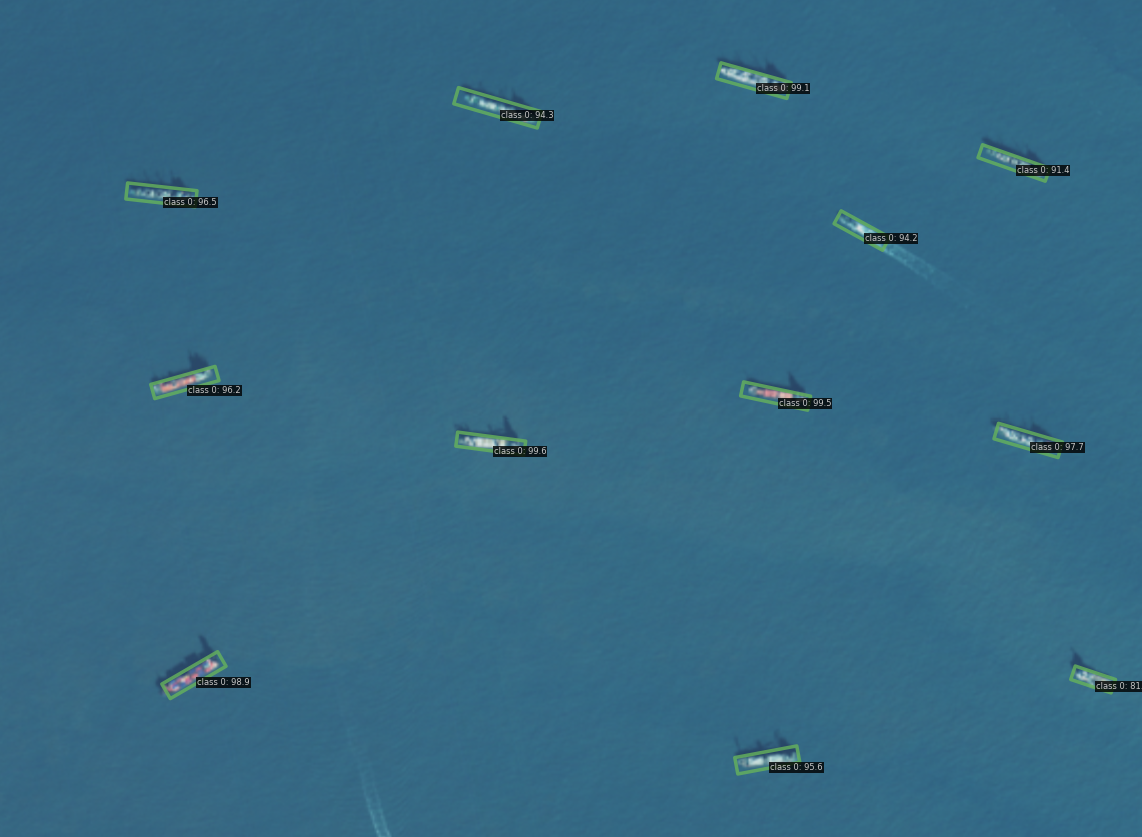

In [92]:
from PIL import Image
from glob import glob
 
# img_path = '/mnt/hdd/eric/.tmp_ipy/00.Data/ShipRS_dataset/ShipRSImageNet_V1/DOTA_Format_MMrotate_1x/images_png/*.png'
# img_list = glob(img_path)
# idx = np.random.randint(0,len(img_list))
# img = img_list[idx]
img = './test2.PNG'


img = mmcv.imread(img)
img = mmcv.imconvert(img, 'bgr', 'rgb')
result = inference_detector(model, img)

visualizer = VISUALIZERS.build(model.cfg.visualizer)
# show the results

visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    show=True,
    wait_time=0,
    pred_score_thr=0.5)
visualizer.show()
img_ = visualizer.get_image()
img_ = Image.fromarray(img_, 'RGB')
img_.save("./demo_/ship_sample_1.png")

img_

# Inference SAM 

In [93]:
args = easydict.EasyDict()
args['type'] = "center"
args['dataset'] = "hrsc"
#args['instance'] = "False"
args['semantic'] = "False"
args['show'] ="True"

EXE_TYPE = ".bmp"

In [94]:
sam_checkpoint = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/06.Gits/SAM_RS/Generate Dataset/SAM_ckpts/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device)
predictor = SamPredictor(sam)

In [95]:
result.pred_instances

<InstanceData(

    META INFORMATION

    DATA FIELDS
    bboxes: tensor([[ 4.9075e+02,  4.4363e+02,  6.8625e+01,  1.4168e+01,  1.3173e-01],
                [ 7.7463e+02,  3.9704e+02,  6.8516e+01,  1.4352e+01,  2.0974e-01],
                [ 7.5292e+02,  8.1652e+01,  7.2994e+01,  1.6417e+01,  2.7474e-01],
                [ 1.9394e+02,  6.7514e+02,  6.4461e+01,  1.6846e+01, -5.2570e-01],
                [ 1.0273e+03,  4.4046e+02,  6.6736e+01,  1.6118e+01,  2.8498e-01],
                [ 1.6142e+02,  1.9585e+02,  6.9813e+01,  1.6140e+01,  1.1151e-01],
                [ 1.8489e+02,  3.8352e+02,  6.6790e+01,  1.4715e+01, -2.7328e-01],
                [ 7.6629e+02,  7.5995e+02,  6.3095e+01,  1.6660e+01, -1.8564e-01],
                [ 4.9787e+02,  1.0881e+02,  8.6903e+01,  1.6844e+01,  2.8235e-01],
                [ 8.6084e+02,  2.3154e+02,  5.5261e+01,  1.4702e+01,  5.0049e-01],
                [ 1.0129e+03,  1.6399e+02,  7.1198e+01,  1.3675e+01,  3.3682e-01],
                [ 1.0921e+03,

In [96]:
pred_boxes = result.pred_instances['bboxes']
pred_scores = result.pred_instances['scores']

box_thr = 0.4


box_list= []
for box,score in zip(pred_boxes,pred_scores):
    box_t = RS_utils.box_converter(box,"4_coord_center","4_coord_minmax")
    if score > box_thr :     
        box_list.append(box_t)   

In [97]:
rotated_boxes = []
for box in box_list:
    x_min, y_min = box[0],box[1]
    x_max, y_max = box[2],box[3]
    angle = box[4]
    
    x_center = x_min + (x_max - x_min)* 1/2
    y_center = y_min + (y_max - y_min)* 1/2
    origin = [x_center, y_center]
    
    rotated_box = []
    
    # to poly 
    poly_box = [[x_min,y_min],[x_min,y_max],[x_max,y_max],[x_max,y_min]]
 
    for point_ in poly_box:
        rotated_point = RS_utils.box_rotate(origin, point_, angle)
        rotated_box.append(rotated_point)
        
    rotated_boxes.append(rotated_box)
    

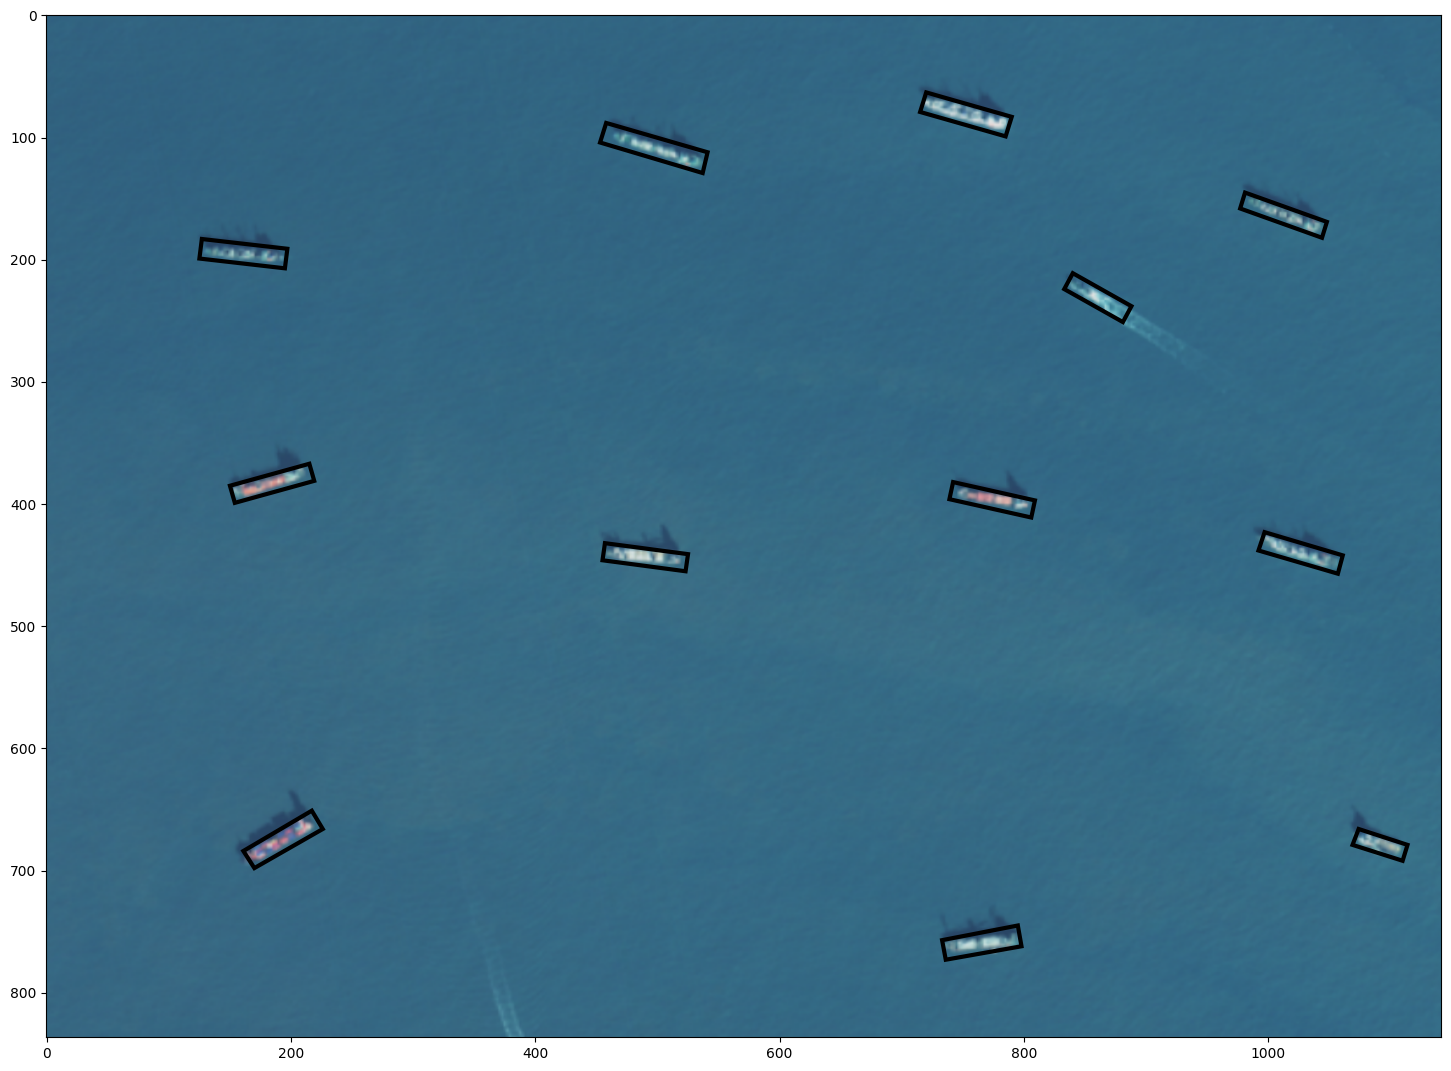

In [98]:
from matplotlib import patches
img_ = img
plt.figure(figsize=(18,18))
plt.imshow(img_)

ax = plt.gca()
for box_ in rotated_boxes:
    #---
    # polygon needs closing point

    #--- 
    path_obj = patches.Polygon(box_, fill=None ,edgecolor='k',ls='solid',lw=3)
    
    ax.add_patch(path_obj)
plt.show()

In [99]:
rectangle_boxes = RS_utils.rotated_to_rectangle(rotated_boxes)

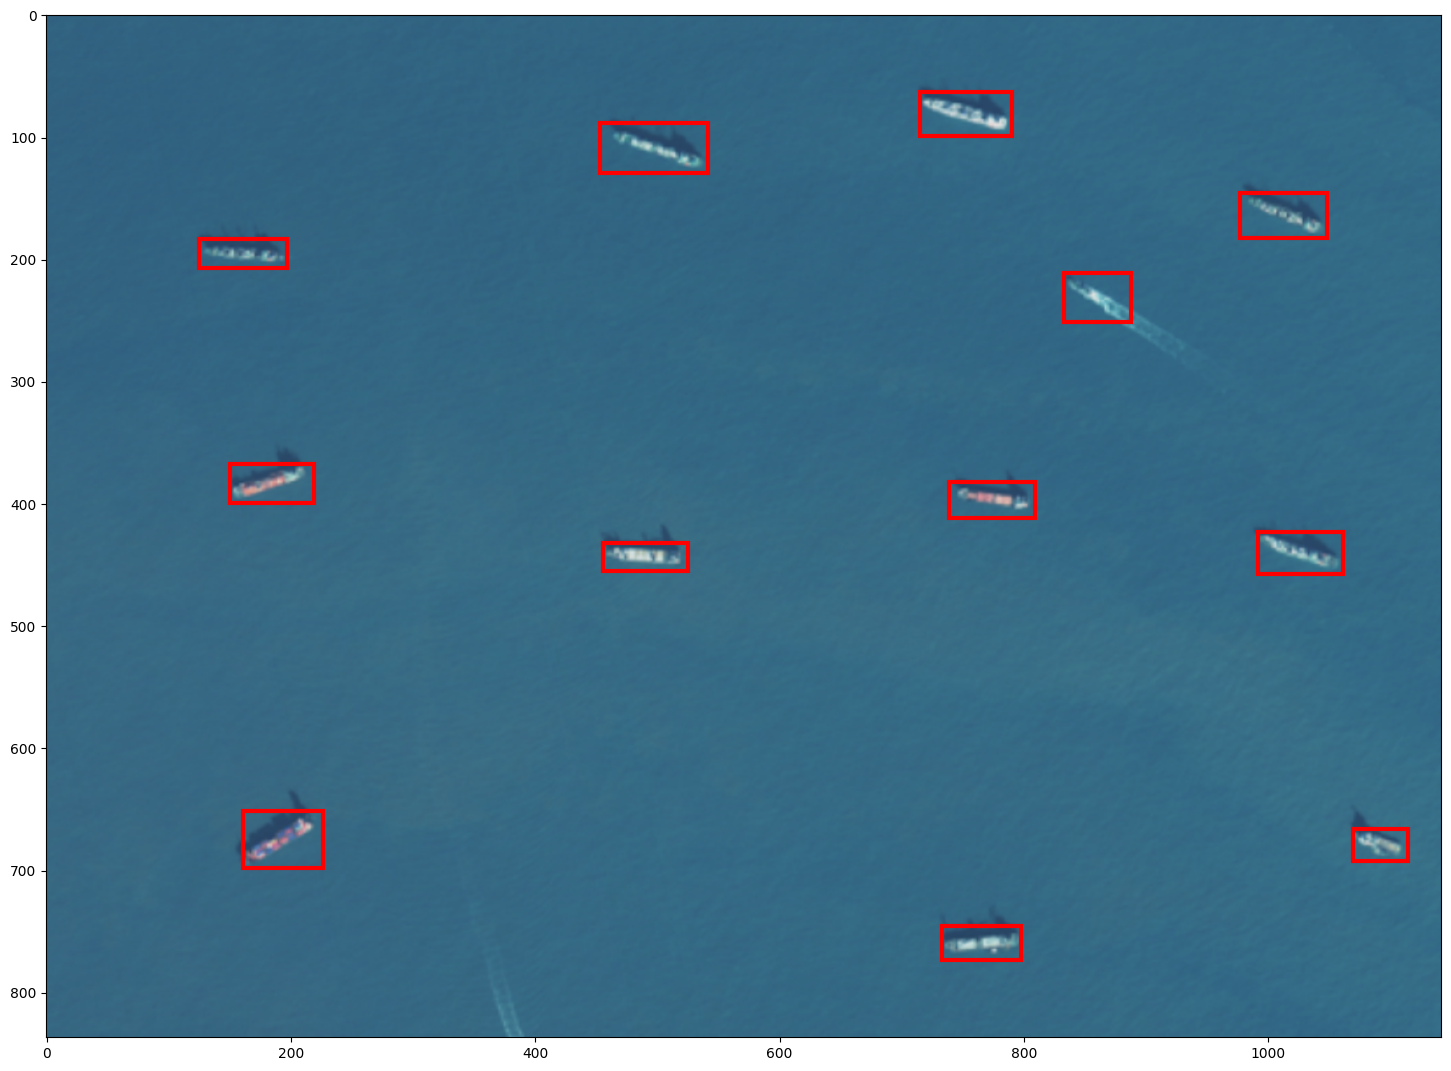

In [100]:
from matplotlib import patches
img_ = img
plt.figure(figsize=(18,18))
plt.imshow(img_)

ax = plt.gca()
for box_ in rectangle_boxes:

    path_obj = patches.Polygon(box_, fill=None ,edgecolor='r',ls='solid',lw=3)
    
    ax.add_patch(path_obj)
plt.show()

In [101]:
rectangle_boxes_sam = np.array(rectangle_boxes)
rectangle_boxes_sam.shape

tmp = rectangle_boxes_sam[:,[0,2],:]
tmp = tmp.reshape(-1,4)
tmp = torch.tensor(tmp)
tmp = tmp.to(device)

transformed_boxes = predictor.transform.apply_boxes_torch(tmp, img.shape[:2])

predictor.set_image(img_)
sam_masks, qualities, lr_logits = predictor.predict_torch(
    point_coords = None,#gt_points[:,None,:],
    point_labels= None,#input_labels[:, None],
    boxes=transformed_boxes,
    mask_input=None,#,rhbox_mask_prompts[:,None,:,:],
    multimask_output=False) # 只输出一个mask

sam_masks = sam_masks.squeeze(1) # b, h, w
sam_masks = sam_masks.cpu().numpy()

(0, 255, 0)
(0, 0, 255)
(255, 255, 0)
(255, 0, 0)
(0, 255, 0)
(0, 0, 255)
(255, 255, 0)
(255, 0, 0)
(0, 255, 0)
(0, 0, 255)
(255, 255, 0)
(255, 0, 0)


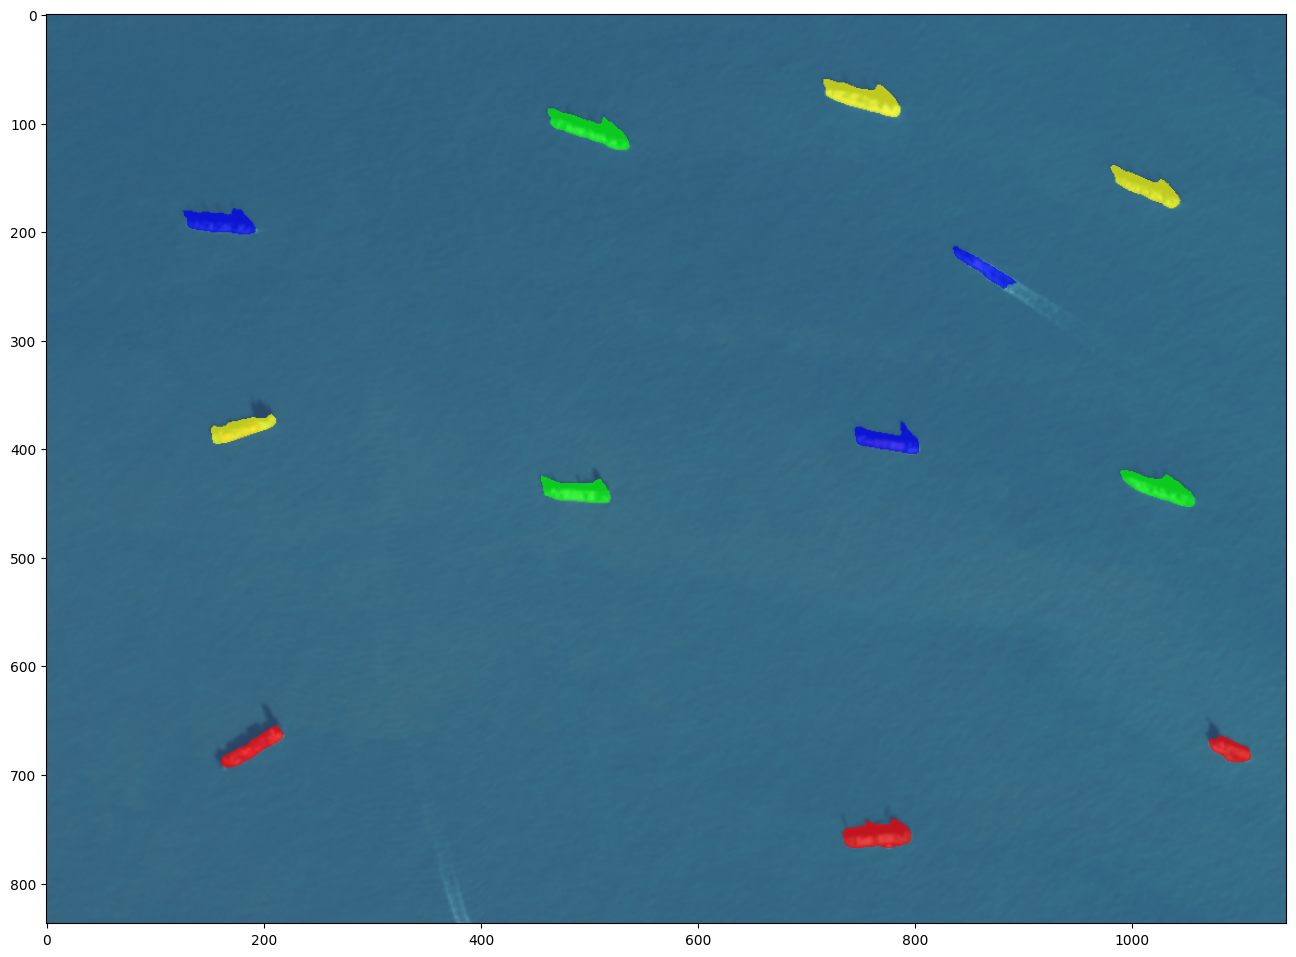

In [102]:
LABELS = [[0], [0]] 
    
COLORS = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 255, 0),  # Yellow
]
segmented_image = RS_utils.draw_masks_fromList(img, [i for i in sam_masks], labels = LABELS, colors=COLORS)

plt.figure(figsize=(16,16))
plt.imshow(segmented_image)

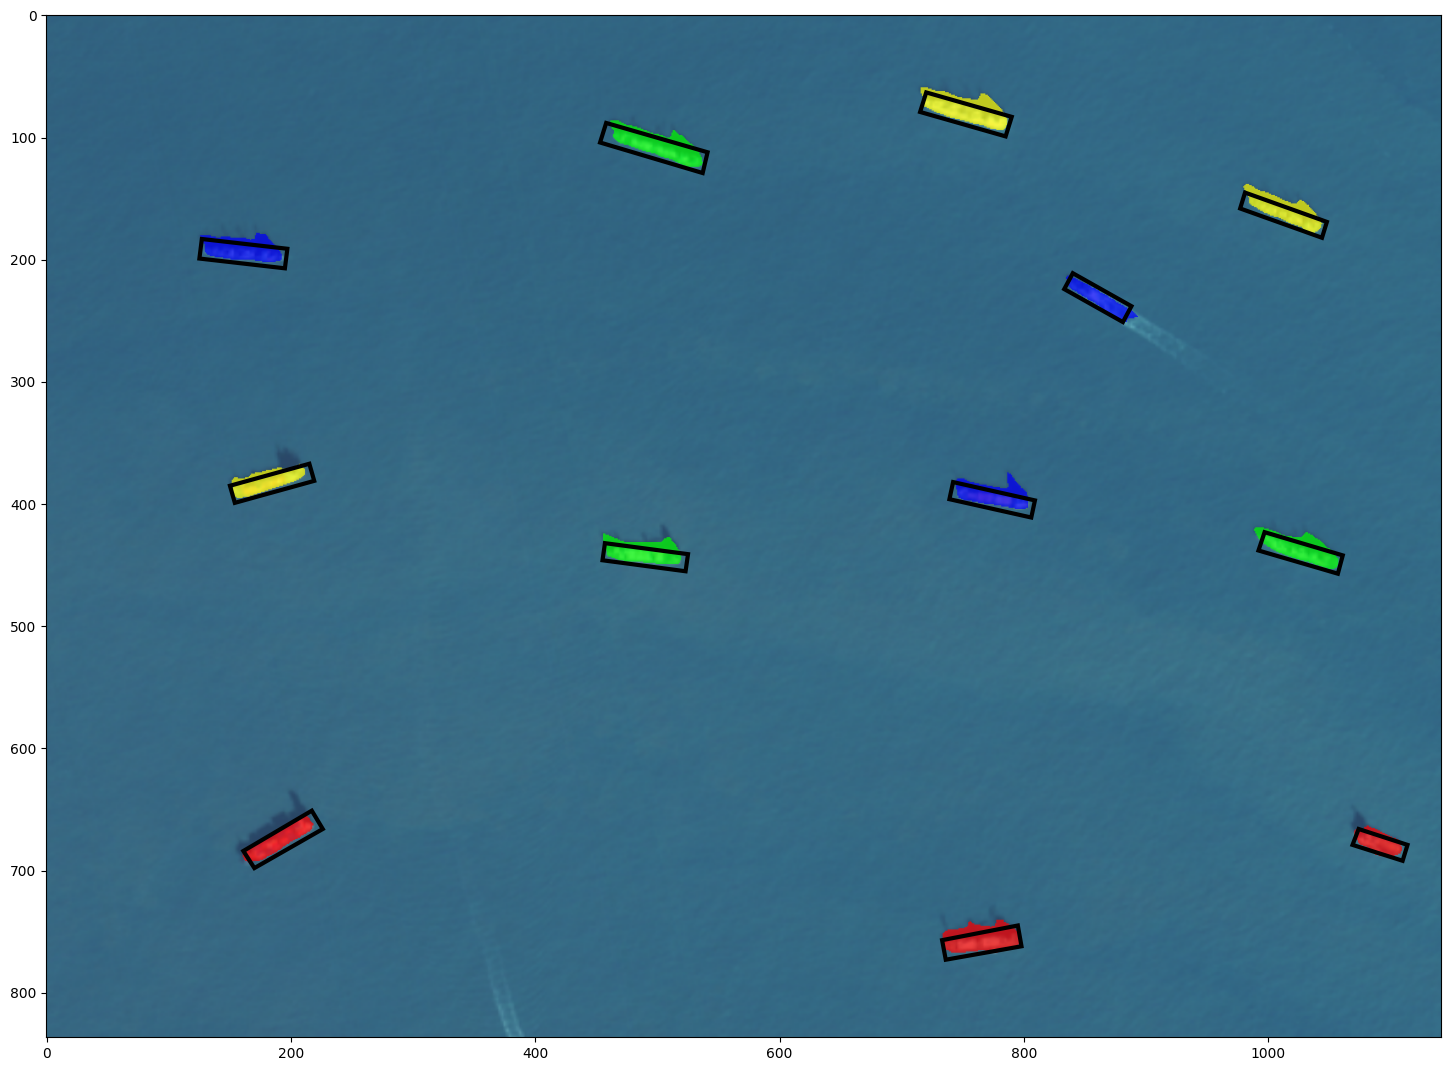

In [103]:
img_ = segmented_image

plt.figure(figsize=(18,18))
plt.imshow(img_)

ax = plt.gca()
for box_ in rotated_boxes:
    #---
    # polygon needs closing point

    #--- 
    path_obj = patches.Polygon(box_, fill=None ,edgecolor='k',ls='solid',lw=3)
    
    ax.add_patch(path_obj)
plt.show()